In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [9]:
figure_name = 'figures/fig_8_2_JND'

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import soundfile as sf
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import scipy.constants
from gammatone import gtgram
from gammatone.plot import render_audio_from_file

import matplotlib.pyplot
import matplotlib.ticker

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [51]:



############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 24

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

############################################################
#               Gammatone Filter Parameters                #
############################################################
t_window = 0.004 # each band then have their energy integrated over windows of window_time seconds,
t_hop = t_window/2 # advancing by hop_time secs for successive columns. 
channels = 24 # number of frequency bands
fmin = 20 # lowest frequency


In [58]:
############################################################
#                       Functions                          #
############################################################

def plot_std_area(dataX,dataY,ax,**kwargs):
    
    
    means = np.mean(dataY,axis=0)
    stds = np.std(dataY,axis=0,ddof=0)
    ax.fill_between(dataX,means-stds, means+stds, **kwargs)
    
    return ax

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p



In [55]:

# Time step
dt = 0.001 # -> 10us
# define the inputs
# assuming we have 16 frquency bands

test_recordings = ['whiteNoise_1_20000Hz_normalEars']
# test_recordings = ['whiteNoise_1_20000Hz_simplePinna','whiteNoise_1_20000Hz_noEars','whiteNoise_1_20000Hz_siliconEars','whiteNoise_1_20000Hz_normalEars',]

test_ilds = [-90,-70,-50,-30,-10,0,10]
test_ilds = np.arange(-90,91,1).astype(int)


# define the sample length manually so that we can be sure all recording samples have the same size
s = np.arange(0,1000)
# store values for different parameters
q_all = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
r_all = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
for l in range(len(test_recordings)):
    test_recording = test_recordings[l]
    for k in range(len(test_ilds)):
        test_ild = test_ilds[k]

        print('Reading recording for '+test_recording+' azimuth : ' + str(test_ild))

        ############################################################
        #                  Input Data Readout                      #
        ############################################################
        stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/OLD/whiteNoise_1_20000Hz_normalEars_JND_1deg_step/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_right.wav'
        data_r = sf.read(stri)[0]
        stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/OLD/whiteNoise_1_20000Hz_normalEars_JND_1deg_step/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_left.wav'
        data_l = sf.read(stri)

        # get the rate
        fs = data_l[1]
        data_l = data_l[0]
        
        
        duration = len(data_l) / fs
        psd_l = gtgram.gtgram(data_l, fs, t_window, t_hop, channels, fmin)
        psd_l = np.flipud(psd_l).T
        # psd_l = np.flipud(20 * np.log10(psd_l)).T

        psd_r = gtgram.gtgram(data_r, fs, t_window, t_hop, channels, fmin)
        psd_r = np.flipud(psd_r).T
        # psd_r = np.flipud(20 * np.l
        
        
        s_gbc_all= psd_l[s]
        s_sbc_all = psd_r[s]


        T = s_gbc_all.shape[0]/1000

        # Solve differential equation from time 0 to time T
        # Descretize time into equal steps
        t = np . linspace (0 , T , int ( T / dt ))


        ############################################################
        #                Network Inputs/Outputs                    #
        ############################################################


        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
        # TODO this normalization is a problem for later ....
        s_gbc_all /= maxi
        s_sbc_all /= maxi


        ############################################################
        #                      Simulation                          #
        ############################################################

        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):

                # E-E kernel
                ee_kernel = gauss(np.arange(0,freq_bands),w,1.0)
                ei_kernel = gauss(np.arange(0,freq_bands),w,1.2)
                ie_kernel = gauss(np.arange(0,freq_bands),w,1.0)
                ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)


                delay_factor = 2
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel)       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel)       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)


    

Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -90
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -89
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -88
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -87
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -86
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -85
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -84
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -83
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -82
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -81
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -80
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -79
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -78
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -77
Reading recording for whiteNoise_1_20000Hz_norma

Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 32
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 33
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 34
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 35
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 36
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 37
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 38
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 39
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 40
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 41
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 42
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 43
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 44
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 45
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth 

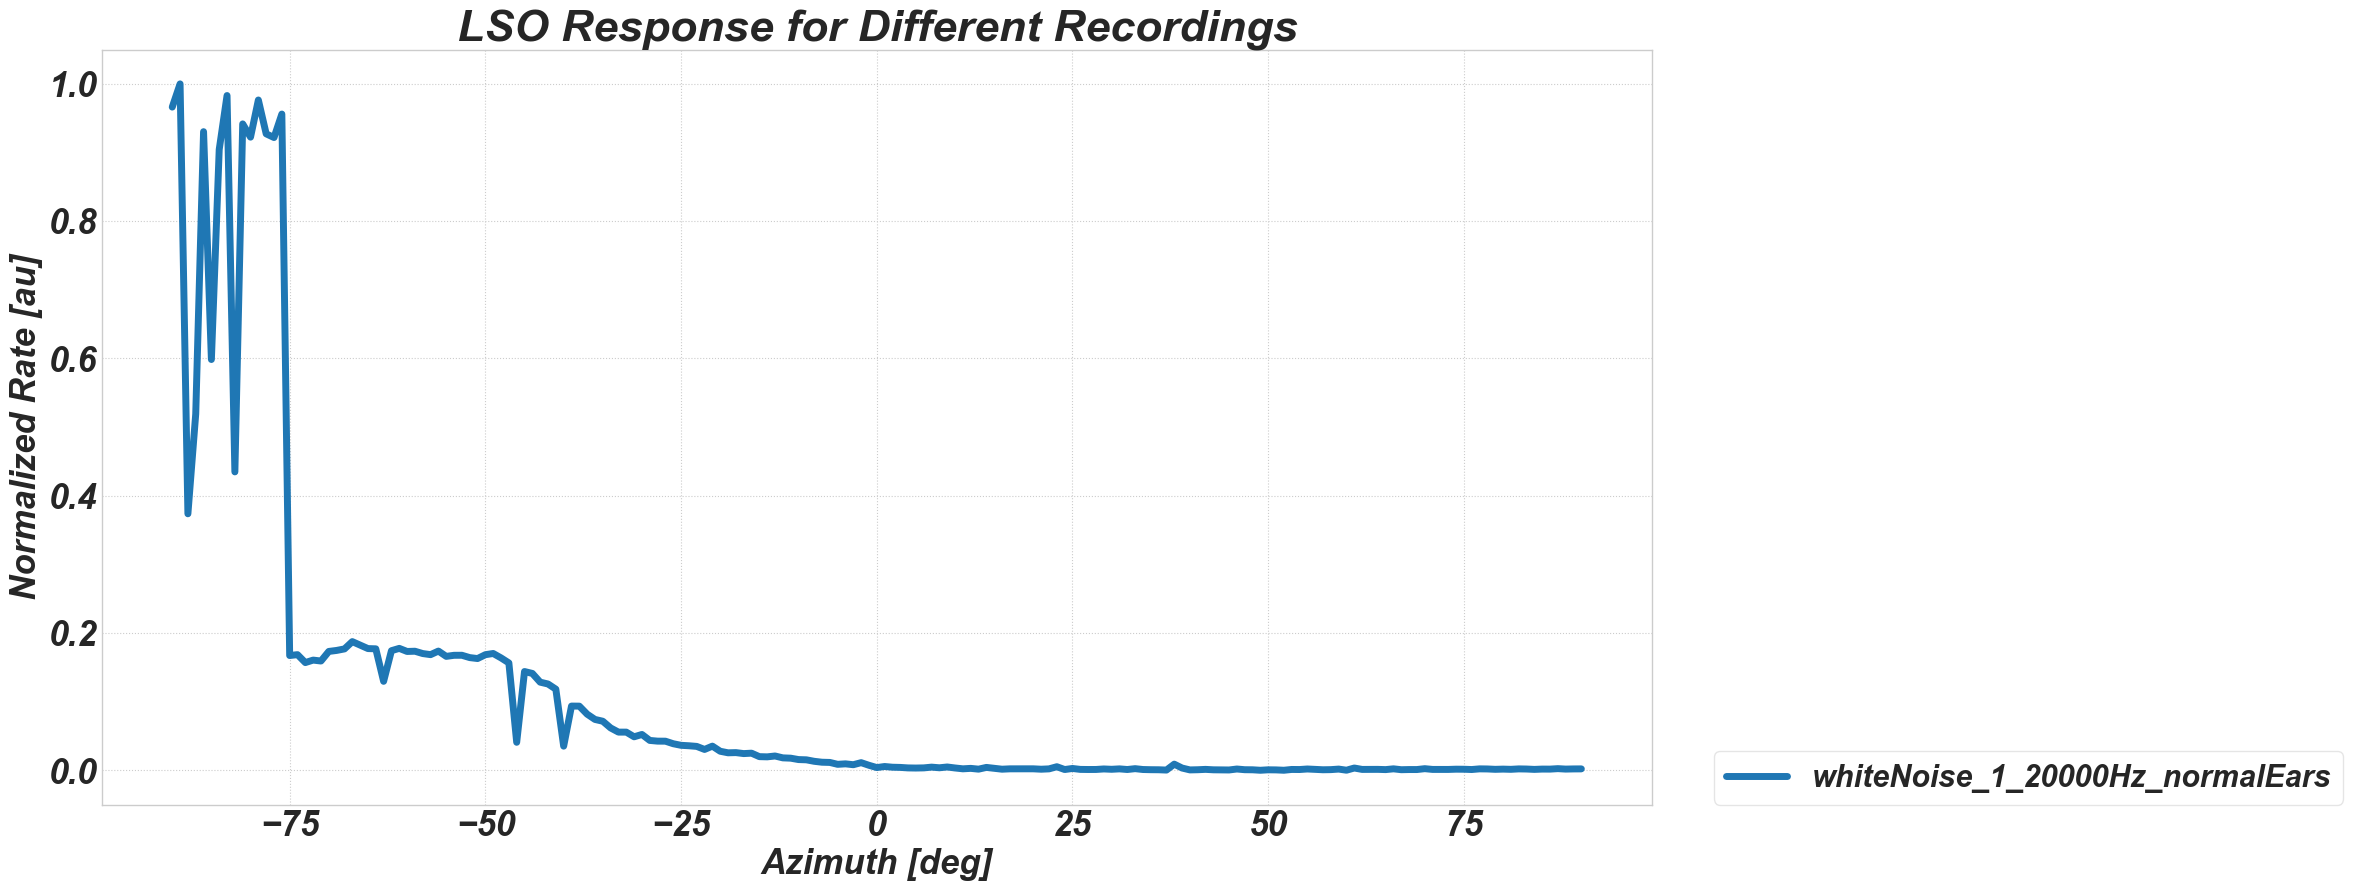

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(test_recordings)):
    ild = np.mean(g_r_out(r_all[i,:,:,:]),axis=(1,2))
    # normalize
    ild -= np.min(ild)
    ild /= np.max(ild)
#     print(ild)
    ax.plot(test_ilds,ild,label=test_recordings[i])
    # we need to add 0 at the beginning and end because it gets cut off ...


# ax.set_xticklabels(np.concatenate([[0],np.linspace(test_ilds[0],test_ilds[-1],len(ax.get_xticks())-2),[0]]))
plt.title('LSO Response for Different Recordings')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Normalized Rate [au]')
lgd = plt.legend(loc=(1.04,0))

plt.savefig(figure_name + 'ild_curve.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'ild_curve.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

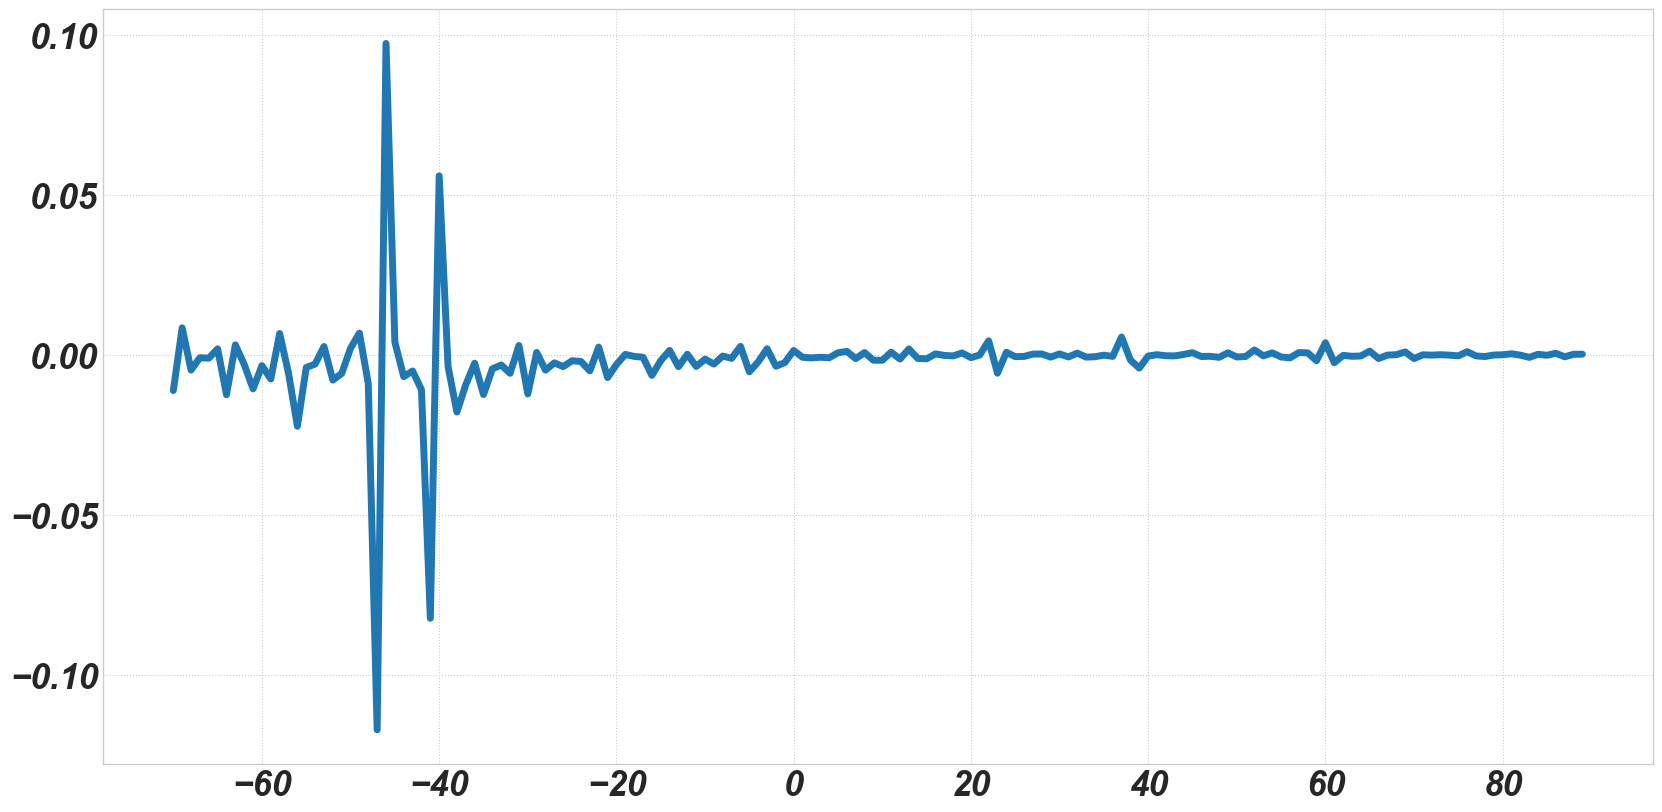

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
test_ilds = np.arange(-90,91,1).astype(int)

ild = np.mean(g_r_out(r_all[i,:,:,:]),axis=(1,2))
# normalize
ild -= np.min(ild)
ild /= np.max(ild)

ild = ild[20:]
test_ilds = test_ilds[20:]
plt.plot(test_ilds[:-1],np.diff(ild))